<h1><center>NYC Taxi Code Challenge</center></h1>

**Instruction manual**

1. This work was done in Python 3 with several packages, including Pandas, Scikit-learn, statsmodels, geopy, xgboost, pickle, seaborn. Please install these packages by **pip install xxxx** before executing the code blocks.
2. Please put the data file and this jupyter notebook in the same directory. 
3. The hyperparameter tuning procedure for the XGBoost regression model took more than **10 hours** on my laptop (macOS 10.14.1, 2.7 GHz i7, 16 GB LPDDR3 Memory, Radeon Pro 455 2G GPU). Please skip this part if you want to do a quick test of the codes. 
4. The pickle file of the optimized XGBoost regression model ("xgb_opt.pkl") is provided along with this jupyter notebook. Please use the following way to load the pickled model. 

In [ ]:
import pickle
with open("xgb_opt.pkl", "rb") as f:
    loaded_model = pickle.load(f)

**Import libraries and settings**

In [158]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from datetime import datetime, timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost
from xgboost import plot_importance, XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# The following settings will ensure all columns of dataframes will be displayed
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

<h1><center>Question 1</center></h1>

**Summary:** 

There are 1494926 rows and 21 columns in the original data set.

### 1.1  Programmatically download and load the Green Taxi trip data for September 2015 into a Pandas dataframe

In [2]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
raw_data = pd.read_csv(url)
raw_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


### 1.2 Report the numbers of rows and columns

In [3]:
print("There are %s rows and %s columns in the original data set." % raw_data.shape)

There are 1494926 rows and 21 columns in the original data set.


<h1><center>Question 2</center></h1>

**Summary:**

1. The trip distance data contains outliers. The trips with 0 distance or with distance longer than 100 miles were removed for the subsequent analysis. 
2. The trip distance follows a lognormal distribution because the logrithm of trip distance follows a normal distribution. 

### 2.1 Plot a histogram of the number of the trip distance (“Trip Distance”)

The following historgram shows the frequency of the trip distance. It can be seen that most trips have a distance less than 50 miles. In very extreme cases, the trip distance can be as long as about 600 miles. 

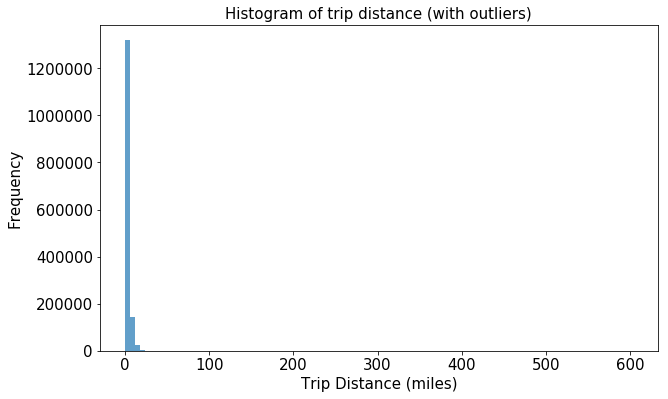

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(raw_data["Trip_distance"], alpha=0.7, bins=100)
plt.title("Histogram of trip distance (with outliers)", fontsize=15)
plt.xlabel("Trip Distance (miles)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Remove trip distances of 0 or longer than 100 miles and plot the histogram again.

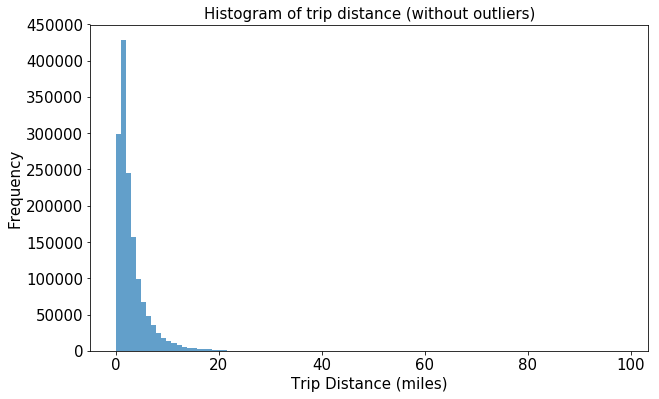

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(raw_data[(raw_data["Trip_distance"]<=100)&(raw_data["Trip_distance"]>0)]["Trip_distance"], alpha=0.7, bins=100)
plt.title("Histogram of trip distance (without outliers)", fontsize=15)
plt.xlabel("Trip Distance (miles)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 2.2 Report any structure you find and any hypotheses you have about that structure.

The distribution is right-skewed with median smaller than mean. It looks similar to the log normal distribution. To prove this hypothesis, take the logrithm of trip distance and see if it follows normal distribution.  

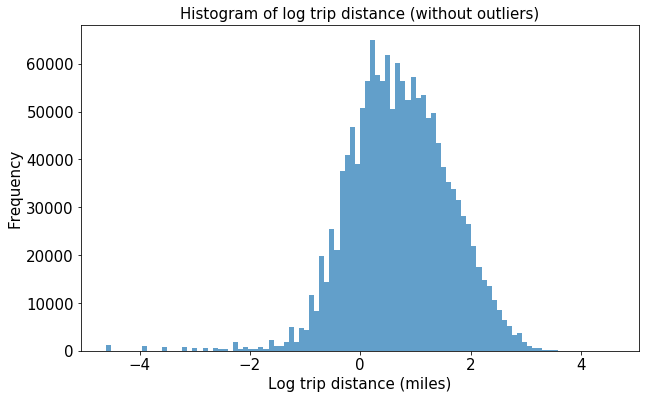

In [6]:
log_distance = np.log(raw_data[(raw_data["Trip_distance"]<=100)&(raw_data["Trip_distance"]>0)]["Trip_distance"].values)

plt.figure(figsize=(10, 6))
plt.hist(log_distance, alpha=0.7, bins=100)
plt.title("Histogram of log trip distance (without outliers)", fontsize=15)
plt.xlabel("Log trip distance (miles)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

It can be seen that the log transformed trip distance follows a normal distribution with a mean around 1.3. Therefore, the original trip distance follows a <font color=red>**lognormal distribution**</font>. 

<h1><center>Question 3</center></h1>

**Summary:**

1. The mean trip distance is always longer than the median distance because the distribution of the trip distance is right-skewed.
2. The mean and median trip distance reach a peak at 5-6am and then decrease until hitting a local minima at 8 am. A possible reason is that these people take taxi to work or school in the morning. To avoid being late due to the rush hour, they took the taxi as early as 5-6 am. After they get off work or school, they chose a cheaper way to go back home, such as taking bus or subway.
3. The result of the data with and without outliers are very similar. The number of outliers are relatively low and they will not seriously influence the data.
4. The trips originating from and terminating to the airports were identified by comparing the latitude and longitude of the pickup/dropoff locations and the airports' locations. <font color=red>**Assuming the 3 airports have a round shape**</font>, if the distance between the pickup/dropoff location and the airport center is shorter than the radius of the airport, the pickup/dropoff will be in the airport. A buffer of 0.25 miles was added to the airport radius to account for the fact that airports are not cicle. <font color=red>**If I have enough time, I will use the real shape of the aiports to get a more accuracte result. To do this, use the coordinates of the airport's vertices points to construct a [polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons) and use the internal method to determine if the pickup/dropoff is in an airport.**</font> 

5. There are 5 major findings by computing the counts, average fare and average distance of the dropoffs/pickups in the 3 airports.
<font color=red>**(1)**</font> There are more dropoffs than pickups in all of the 3 airports. <font color=red>**(2)**</font> It is also very suprising that LGA has the most number of dropoffs and pickups even though it is the smallest airport among the 3.
<font color=red>**(3)**</font> The average fares of the EWR pickups and dropoffs are the highest. The average fares of JFK pickups and dropoffs are medium. The average fares of LGA pickups and dropoffs are the lowest.
<font color=red>**(4)**</font> The average trip distance for dropoffs is longer than pickups for all 3 airports. The dropoffs at EWR have the longest average trip distance. LGA has the shortest pickup and dropoff average distances.
<font color=red>**(5)**</font> The average fare and average distance may be able to explain why LGA has a higher number of dropoffs and pickups even if it is the smallest airport among the 3. The major reason is that it's closer to most passengers and as a result, the average taxi fare is also lower.

### 3.1 Report mean and median trip distance grouped by hour of day

It's better to use dropoff hour to group the data because it is the trip finish time. First extract the dropoff datetime and trip distance from the raw data. 

In [7]:
time_trip = raw_data[["Lpep_dropoff_datetime", "Trip_distance"]] 
time_trip.head()

,Lpep_dropoff_datetime,Trip_distance
0,2015-09-01 00:02:38,0.00
1,2015-09-01 00:04:24,0.00
2,2015-09-01 00:04:24,0.59
3,2015-09-01 00:06:42,0.74
4,2015-09-01 00:04:20,0.61


Define a function to extract the hours from the Lpep_dropoff_datetime variable.

In [8]:
def extract_hour(date_time):    
    obj = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")
    return obj.hour

Create a new variable called "dropoff_hour" to store the extracted hours.

In [9]:
time_trip["dropoff_hour"] = time_trip["Lpep_dropoff_datetime"].apply(lambda x: extract_hour(x))
time_trip.head()

,Lpep_dropoff_datetime,Trip_distance,dropoff_hour
0,2015-09-01 00:02:38,0.00,0
1,2015-09-01 00:04:24,0.00,0
2,2015-09-01 00:04:24,0.59,0
3,2015-09-01 00:06:42,0.74,0
4,2015-09-01 00:04:20,0.61,0


Group the trip distance by dropoff hours and caluculate the mean and median of each group.

In [10]:
# Original data
group_dist = time_trip.groupby(["dropoff_hour"]).agg(["mean","median"])
group_dist.columns = group_dist.columns.droplevel(0)
group_dist.reset_index(level=['dropoff_hour'], inplace=True)
group_dist.rename(columns={"mean":"mean_distance", "median":"median_distance"}, inplace=True)

# The data with outliers (distance > 100 miles or distance = 0) removed
time_trip_no_outlier = time_trip[(time_trip["Trip_distance"]<=100)&(time_trip["Trip_distance"]>0)]
group_dist_no_outlier = time_trip_no_outlier.groupby(["dropoff_hour"]).agg(["mean","median"])
group_dist_no_outlier.columns = group_dist_no_outlier.columns.droplevel(0)
group_dist_no_outlier.reset_index(level=['dropoff_hour'], inplace=True)
group_dist_no_outlier.rename(columns={"mean":"mean_distance_no_outlier", "median":"median_distance_no_outlier"}, inplace=True)

# Display the mean and median of trip distances
group_dist_both = pd.merge(group_dist,group_dist_no_outlier, how="left", on="dropoff_hour")
group_dist_both

,dropoff_hour,mean_distance,median_distance,mean_distance_no_outlier,median_distance_no_outlier
0,0,3.239356,2.28,3.271212,2.30
1,1,3.130531,2.20,3.167283,2.23
2,2,3.143715,2.21,3.188660,2.25
3,3,3.225473,2.26,3.254853,2.30
4,4,3.463798,2.37,3.516752,2.41
5,5,4.187841,2.92,4.266515,3.00
6,6,3.932660,2.76,4.018686,2.81
7,7,3.217171,2.05,3.266918,2.10
8,8,2.923779,1.87,2.964795,1.90
9,9,3.016995,1.98,3.058360,2.00


Plot the mean and median trip distance by dropoff hour.

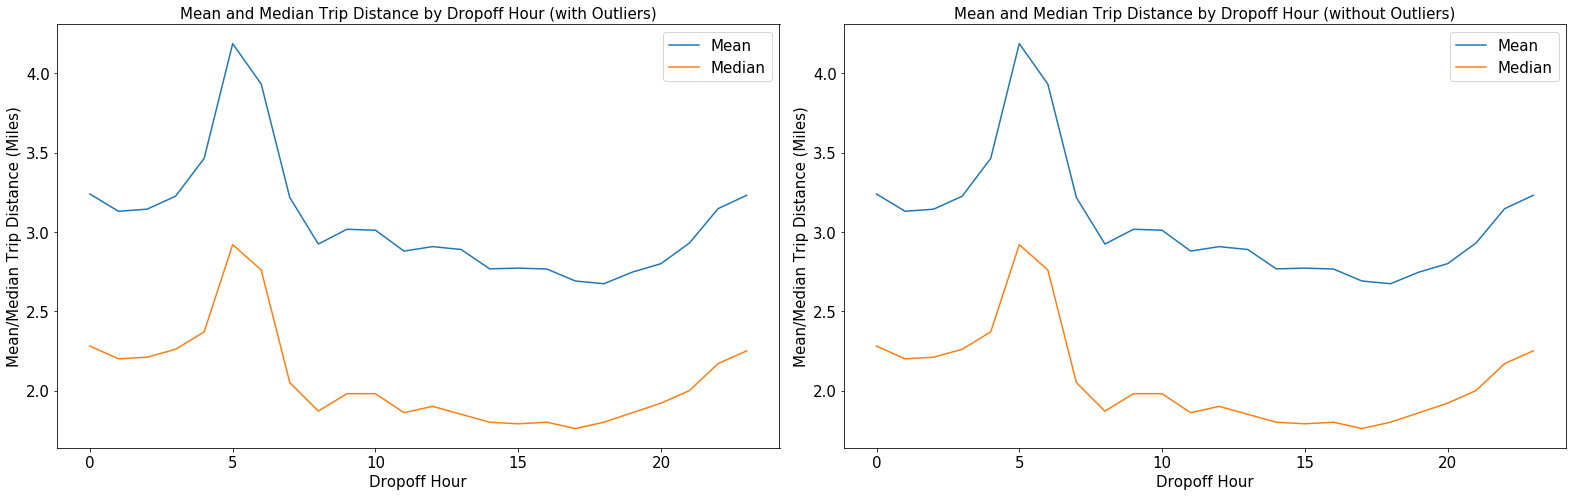

In [11]:
plt.figure(figsize=(22, 7))

plt.subplot(1,2,1)
plt.plot(group_dist_both["dropoff_hour"], group_dist_both["mean_distance"])
plt.plot(group_dist_both["dropoff_hour"], group_dist_both["median_distance"])
plt.title("Mean and Median Trip Distance by Dropoff Hour (with Outliers)", fontsize=15)
plt.xlabel("Dropoff Hour", fontsize=15)
plt.ylabel("Mean/Median Trip Distance (Miles)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(["Mean", "Median"], fontsize=15)

plt.subplot(1,2,2)
plt.plot(group_dist_both["dropoff_hour"], group_dist_both["mean_distance"])
plt.plot(group_dist_both["dropoff_hour"], group_dist_both["median_distance"])
plt.title("Mean and Median Trip Distance by Dropoff Hour (without Outliers)", fontsize=15)
plt.xlabel("Dropoff Hour", fontsize=15)
plt.ylabel("Mean/Median Trip Distance (Miles)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(["Mean", "Median"], fontsize=15)

plt.tight_layout()

There are 3 main findings:

1. The mean trip distance is always longer than the median distance because the distribution of the trip distance is right-skewed.
2. The mean and median trip distance reach a peak at 5-6am and then decrease until hitting a local minima at 8 am. A possible reason is that these people take taxi to work or school in the morning. To avoid being late due to the rush hour, they took the taxi as early as 5-6 am. After they get off work or school, they chose a cheaper way to go back home, such as taking bus or subway.
3. The result of the data with and without outliers are very similar. The number of outliers are relatively low and they will not seriously influence the data.

### 3.2  Identify trips that originate or terminate at one of the NYC area airports. Report the number of transactions, the average fare and other interesting characteristics. 

There are 3 airports in the NYC area: 
- John F. Kennedy International Airports (JFK)
- LaGuardia Airport (LGA)
- Newark Liberty International Airport (EWR)

There are 2 ways to identify trips that originate or terminate at one of the airports.
1. There is a ”RateCodeID“ attribute in the dataset showing the final rate code in effect at the end of the trip. According to [Data Dictionary](http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf) and [NYC Taxicab Rate of Fare](http://www.nyc.gov/html/tlc/html/industry/taxicab_rate_yellow.shtml), codes 2 and 3 indicate the trip's final destination is JFK Airport or EWR Airport. However, this method can only tell the trip terminate in an airport and cannot tell if the trip originates from an airport. In addition, there is no code for the LGA airport. 
2. Each trip has the longtidute and the latitute of the pickup and dropoff. This information can be used to calculate their distance to the 3 airports in the NYC area.

**The second way was used to identify trips that are originate or terminate at one of the airports.**

Extract the longtidute and the latitute of the pickup and dropoff.

In [12]:
lat_log = raw_data[["Pickup_longitude", "Pickup_latitude", "Dropoff_longitude", "Dropoff_latitude"]] 
lat_log.head()

,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude
0,-73.979485,40.684956,-73.979431,40.685020
1,-74.010796,40.912216,-74.010780,40.912212
2,-73.921410,40.766708,-73.914413,40.764687
3,-73.921387,40.766678,-73.931427,40.771584
4,-73.955482,40.714046,-73.944412,40.714729


According to [Coordinates Finder](https://www.coordinatesfinder.com/), the coordiates (latitude, logitude) of the 3 airports are:
- JFK: (40.6413111, -73.7781391)
- LGA: (40.775399, -73.874583)
- EWR: (40.6895314, -74.1744624)

According to the [Airport Traffic Report by the Port Authority of NY & NJ](https://www.panynj.gov/airports/pdf-traffic/ATR2016.pdf), the area covered by the 3 airports are:

- JFK: 4930 acres = 7.7031 miles<sup>2</sup>
- LGA: 680 acres = 1.0625 miles<sup>2</sup>
- EWR: 2027 acres = 3.1672 miles<sup>2</sup>

Assuming these 3 airports take up round regions, then the radii of the airports will be:
- JFK: 1.5660 miles
- LGA: 0.5816 miles
- EWR: 1.0041 miles

Define a function to check if the pickup/dropoff position is within the areas of the 3 airports. The [geodesic function](https://pypi.org/project/geopy/) in the geopy package was used to calculate the geodesic distance between 2 locations. 

In [13]:
def within_airports(df_row):
    # coordinates of the 3 airports
    JFK = (40.6413111, -73.7781391)
    LGA = (40.775399, -73.874583)
    EWR = (40.6895314, -74.1744624)
    
    # radii of the 3 airports
    JFK_r = 1.5660
    LGA_r = 0.5816
    EWR_r = 1.0041
    
    # use a quarter mile as a buffer to account for that airports are not circle in reality
    buffer = 0.25
    
    airport_coor = [JFK, LGA, EWR]
    airport_radii = [JFK_r, LGA_r, EWR_r]
    
    # coordinates of the trips
    pickup = (df_row["Pickup_latitude"], df_row["Pickup_longitude"])
    dropoff = (df_row["Dropoff_latitude"], df_row["Dropoff_longitude"])
    
    location_coor = [pickup, dropoff]
        
    # calculate pairwise geodesic distance beween airport centers and the pickup/dropoff location
    # use the radii of airports to determine if the trips are within the area of the airports. 
    within_status = list()
    for i in range(3):
        for j in range(2):
            dist = geodesic(airport_coor[i], location_coor[j]).miles
            within = 0
            if dist <= airport_radii[i] + buffer:
                within = 1
            within_status.append(within)
    
    return tuple(within_status)

Create 6 new features "JFK_pickup","JFK_dropoff", "LGA_pickup", "LGA_dropoff", "EWR_pickup", "EWR_dropoff" to indicate if the trip is a dropoff or pickup from one of the 3 airports.

In [14]:
status_columns = ["JFK_pickup","JFK_dropoff", "LGA_pickup", "LGA_dropoff", "EWR_pickup", "EWR_dropoff"]
lat_log[status_columns] = lat_log.apply(lambda row: pd.Series(within_airports(row)), axis=1)
lat_log.head()

,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,JFK_pickup,JFK_dropoff,LGA_pickup,LGA_dropoff,EWR_pickup,EWR_dropoff
0,-73.979485,40.684956,-73.979431,40.685020,0,0,0,0,0,0
1,-74.010796,40.912216,-74.010780,40.912212,0,0,0,0,0,0
2,-73.921410,40.766708,-73.914413,40.764687,0,0,0,0,0,0
3,-73.921387,40.766678,-73.931427,40.771584,0,0,0,0,0,0
4,-73.955482,40.714046,-73.944412,40.714729,0,0,0,0,0,0


Join the airport dropoff/pickup status back to the original data. 

In [15]:
q3_data = pd.merge(raw_data, lat_log[["JFK_pickup","JFK_dropoff", "LGA_pickup", "LGA_dropoff", 
        "EWR_pickup", "EWR_dropoff"]], left_index=True, right_index=True)
q3_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,JFK_pickup,JFK_dropoff,LGA_pickup,LGA_dropoff,EWR_pickup,EWR_dropoff
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0,0,0,0,0,0,0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0,0,0,0,0,0,0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0,0,0,0,0,0,0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0,0,0,0,0,0,0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0,0,0,0,0,0,0


- **Get counts of the dropoff and pickup in each of the 3 airports.**

In [18]:
q3_data[["JFK_pickup","JFK_dropoff", "LGA_pickup", "LGA_dropoff", "EWR_pickup", "EWR_dropoff"]].sum()

JFK_pickup       381
JFK_dropoff    13713
LGA_pickup      1139
LGA_dropoff    24756
EWR_pickup        42
EWR_dropoff      724
dtype: int64

An interesting finding is that there are more dropoffs than pickups in all of the 3 airports. It is also very suprising that LGA has the most number of dropoffs and pickups even though it is the smallest airport among the 3. 

- **Get average fare of the dropoff and pickup in each of the 3 airports.**

First plot the distribution of the total fare amount with and without outliers. It can be seen that outliers are trips with total amount ≤ 0 or total amount > 200.

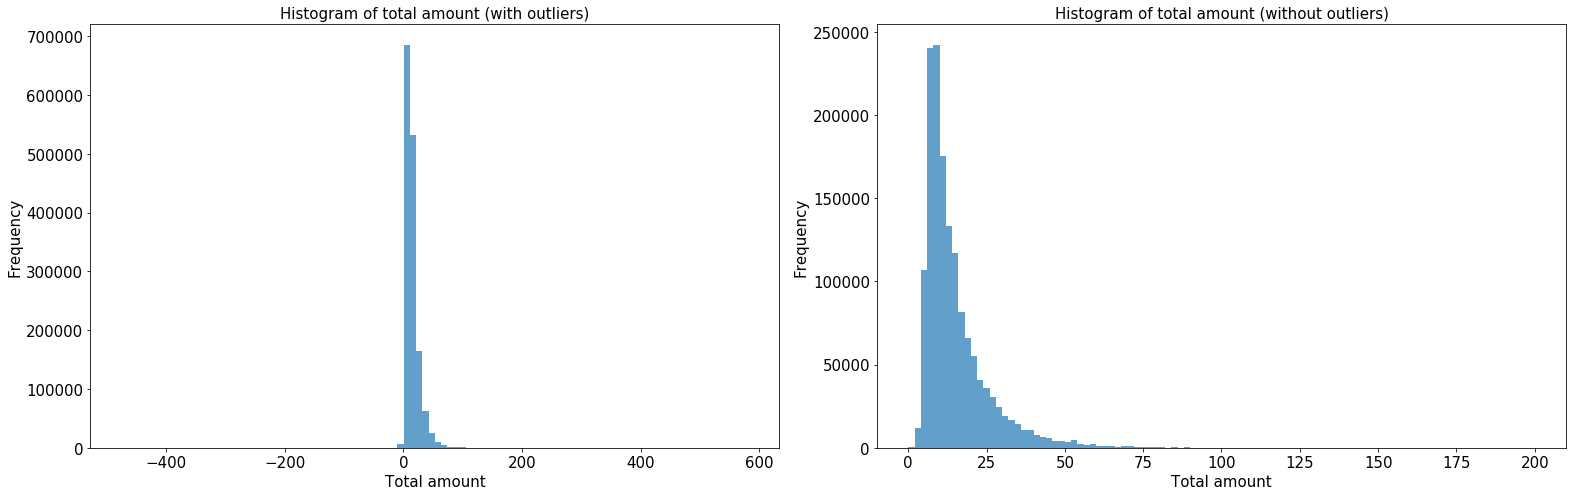

In [33]:
plt.figure(figsize=(22, 7))

plt.subplot(1,2,1)
plt.hist(q3_data["Total_amount"], alpha=0.7, bins=100)
plt.title("Histogram of total amount (with outliers)", fontsize=15)
plt.xlabel("Total amount", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
plt.hist(q3_data[(q3_data["Total_amount"]>0)&(q3_data["Total_amount"]<=200)]["Total_amount"], alpha=0.7, bins=100)
plt.title("Histogram of total amount (without outliers)", fontsize=15)
plt.xlabel("Total amount", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

Get the average fare for trips without outliers.

In [34]:
for status in ["JFK_pickup","JFK_dropoff", "LGA_pickup", "LGA_dropoff", "EWR_pickup", "EWR_dropoff"]:
    temp = q3_data[(q3_data["Total_amount"]>0)&(q3_data["Total_amount"]<=200)][["Total_amount", status]].groupby(status).mean().reset_index()
    temp = temp[temp[status]==1]
    temp.rename(columns={"Total_amount":"Average_fare"}, inplace=True)
    print(temp)

   JFK_pickup  Average_fare
1           1     39.233113
   JFK_dropoff  Average_fare
1            1     47.596729
   LGA_pickup  Average_fare
1           1     21.612173
   LGA_dropoff  Average_fare
1            1     24.361845
   EWR_pickup  Average_fare
1           1     73.502683
   EWR_dropoff  Average_fare
1            1     97.743121


It can be seen that the average fares of the EWR pickups and dropoffs are the highest. The average fares of JFK pickups and dropoffs are medium. The average fares of LGA pickups and dropoffs are the lowest. 

- **Get average trip distance of the dropoff and pickup in each of the 3 airports.**

Based on result of question 2, the trip distance has outliers with a distance > 100 miles or a distance = 0. We need to remove them in the analysis.

In [37]:
for status in ["JFK_pickup","JFK_dropoff", "LGA_pickup", "LGA_dropoff", "EWR_pickup", "EWR_dropoff"]:
    temp = q3_data[(q3_data["Trip_distance"]>0)&(q3_data["Trip_distance"]<=100)][["Trip_distance", status]].groupby(status).mean().reset_index()
    temp = temp[temp[status]==1]
    temp.rename(columns={"Trip_distance":"Average_trip_distance"}, inplace=True)
    print(temp)

   JFK_pickup  Average_trip_distance
1           1                8.32386
   JFK_dropoff  Average_trip_distance
1            1              13.603496
   LGA_pickup  Average_trip_distance
1           1               4.512562
   LGA_dropoff  Average_trip_distance
1            1               5.812597
   EWR_pickup  Average_trip_distance
1           1               7.871333
   EWR_dropoff  Average_trip_distance
1            1              21.200863


It can be seen that the average trip distance for dropoffs is longer than pickups for all 3 airports. The dropoffs at EWR have the longest average trip distance of 21.2 miles. LGA has the shortest pickup and dropoff average distances. 

**Conclusion:** The average fare and average distance may be able to explain why LGA has a higher number of dropoffs and pickups even if it is the smallest airport among the 3. The major reason is that it's closer to most passengers and as a result, the average taxi fare is also lower. 

<h1><center>Question 4</center></h1>

**Summary:**

In this question, I have built a predictive model for tip as a percentage of the total fare. Data cleaning, feature engineering, and feature reduction were done before modeling. The XGBoost regression algorithm was selected because of the algorithm's generally better performance. The optimized model achieved a root mean squared error of 7.2 on the test set. The steps are summarized as follows. 
1. A variable was derived for tip as a percentage of the total fare through divding the tip amount by total amount.
2. In the original data, only tips paid by credit card were recorded. The 0's in the trips paid by cash are actually missing values. There was no data to show the tips paid by cash. Therefore, <font color=red>**this problem need to be reduced to the prediction of tip as a percentage of the total fare paid by credit cards.**</font> In the data cleaning step, all the trips not paid by credit cards were removed. 
3. Other data quality issues, such as missing values, redundent variables, data errors were handled in data cleaning.
4. Categorical variables were one-hot encoded. The pickup and dropoff time were parsed to extract more information about the time, including hour, day of week, day of month, duration, average trip speed. The pickup and dropoff latitude and logitude were used to create 4 features representing the direction of the trip (NE, NW, SE, SW). <font color=red>**If I have enough time, I can create more features. It is possible to use the latitude and longitude to map with Census Bureau's data to get aggregated information about the socioeconomic factors (income, education level, occupation) and demographics data. It is also possible to map the location and time with historical weather data to get more variables.**</font>
5. The feature space were reduced by removing numerical variables with high multicolinearity. Pairwise correlation and VIF were used to identify variables with multicolinearity. 
6. The XGBoost algorithm was used to build the regression model. The data was splited into a training set and a test set (8:2). The hyperparameters of the XGBoost regressor was tuned by grid search to minimize the mean squared error on the training data. The optimized model achieved a root mean squared error of 7.2 on the test set and is very close to the training set (7.17).
7. The average speed, trip distance, hour of day, day of month, day of week are important predictors in this model. 

### 4.1 Build a derived variable for tip as a percentage of the total fare

Create a copy of the original raw data

In [38]:
q4_data = raw_data.copy()

In [40]:
print("There are %s trips with the total fare amount ≤ 0." %len(q4_data[q4_data["Total_amount"]<=0]))

There are 6589 trips with the total fare amount ≤ 0.


To create the dervied variable, divide "Tip_amount" by "Total_amount". 6589 transactions have the "Total_amount" ≤ 0. In this case, use NULL as the value of the derived variable. 

In [41]:
q4_data["Tip_percent"] = q4_data.apply(lambda row: 100*row["Tip_amount"]/row["Total_amount"] if row["Total_amount"]>0 else np.NAN, axis=1)
q4_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,Tip_percent
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0,20.00000
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0,0.00000
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0,8.62069
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0,0.00000
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0,0.00000


Plot the distribution of tip as percent of total amount.

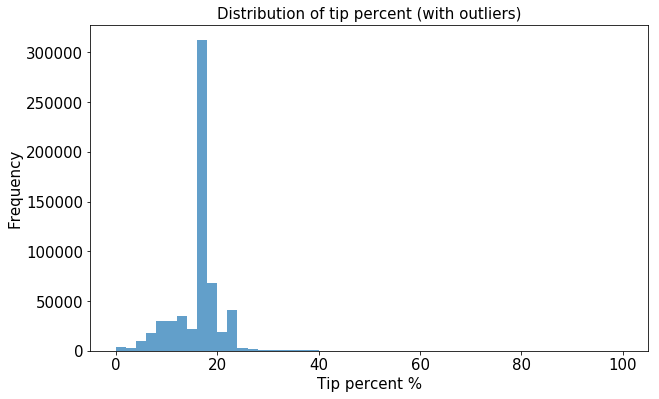

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(q4_data[q4_data["Tip_percent"]>0]["Tip_percent"], alpha=0.7, bins=50)
plt.title("Distribution of tip percent (with outliers)", fontsize=15)
plt.xlabel("Tip percent %", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

It can be seen that most tips are higher than 15% but less than 20% of the total amount. 

### 4.2 Build a predictive model for tip as a percentage of the total fare

### - Data Cleaning

- **Remove white spaces in attribute names**

In [48]:
q4_data.columns = q4_data.columns.str.strip()

- **Remove transactions that were not paid by credit cards**

According to the data dictionary, "Tip_amount" are for credit card tips only. Cash tips were not recorded. "Total_amount" doesn't include cash tips either. In other words, many 0's in the "Tip_amount" attribute are not real 0's. They are actually **missing values** because they were paid by cash and not recorded.

<font color=red>**Because there is no data about the tips paid by cash, we need to limit the task to the prediction of tip as a percentage of the total fare paid by credit card.**</font>

Remove transactions not paid by credit cards and drop the payment type variable.

In [49]:
q4_data = q4_data[q4_data["Payment_type"]==1]
q4_data.drop(["Payment_type"], axis=1, inplace=True)
print("%s samples have been removed from the data." % (len(raw_data) - len(q4_data)))

793639 samples have been removed from the data.


- **Handle missing values**

In [50]:
q4_data.isnull().sum()

VendorID                      0
lpep_pickup_datetime          0
Lpep_dropoff_datetime         0
Store_and_fwd_flag            0
RateCodeID                    0
Pickup_longitude              0
Pickup_latitude               0
Dropoff_longitude             0
Dropoff_latitude              0
Passenger_count               0
Trip_distance                 0
Fare_amount                   0
Extra                         0
MTA_tax                       0
Tip_amount                    0
Tolls_amount                  0
Ehail_fee                701287
improvement_surcharge         0
Total_amount                  0
Trip_type                     3
Tip_percent                 323
dtype: int64

It can be seen the variable "Ehail_fee" doesn't have any values and should be dropped. 3 transactions have missing "Trip_type". The derived variable "Tip_percent" has 323 missing values because the corresponding "Total_amount" is ≤ 0. They should be removed.

In [51]:
q4_data.drop(["Ehail_fee"], axis=1, inplace=True)
q4_data.dropna(subset=["Trip_type"], inplace=True)
q4_data.dropna(subset=["Tip_percent"], inplace=True)
q4_data.shape

(700961, 20)

- **Remove redundent variables**

Because the task is to predict the tip as a percentage of the total fare, we need to remove "Tip_amount" from the data. Otherwise, the algorithm will easily learn to calculate the tip percentage by a simple math. In addition, "Total_amount" is the sum of "Fare_amount", "Extra", “MTA_tax", "Tip_amount", "Tolls_amount", and "improvement_surcharge". It's possible to get the tip by knowing other fees. Therefore, "Total_amount" should be removed, too. 

In [52]:
q4_data.drop(["Tip_amount","Total_amount"], axis=1, inplace=True)
q4_data.shape

(700961, 18)

- **Remove transactions with error data**

Below are the criterion of the numerical variables. 

1. Passenger_count, Trip_distance, Fare_amount should be > 0. 
2. Extra, MTA_tax, Tolls_amount, Tip_percent, improvement_surcharge should be ≥ 0. 
3. Dropoff time should be later than pickup time. 
4. Dropoff location should be different from the pickup location. 

Remove transactions don't meet these criterion.

In [53]:
q4_data = q4_data[(q4_data["Passenger_count"]>0)&(q4_data["Trip_distance"]>0)&(q4_data["Fare_amount"]>0)
            &(q4_data["Extra"]>=0)&(q4_data["MTA_tax"]>=0)&(q4_data["Tip_percent"]>=0)&(q4_data["Tolls_amount"]>=0)
            &(q4_data["improvement_surcharge"]>=0)&(q4_data["Lpep_dropoff_datetime"]>q4_data["lpep_pickup_datetime"])
            &(q4_data["Dropoff_latitude"]!=q4_data["Pickup_latitude"])
            &(q4_data["Dropoff_longitude"]!=q4_data["Pickup_longitude"])]
q4_data.shape

(691476, 18)

- **Handle undocumented categorical variable levels**

Plot categorical variables to check if there are any undocumented levels. 

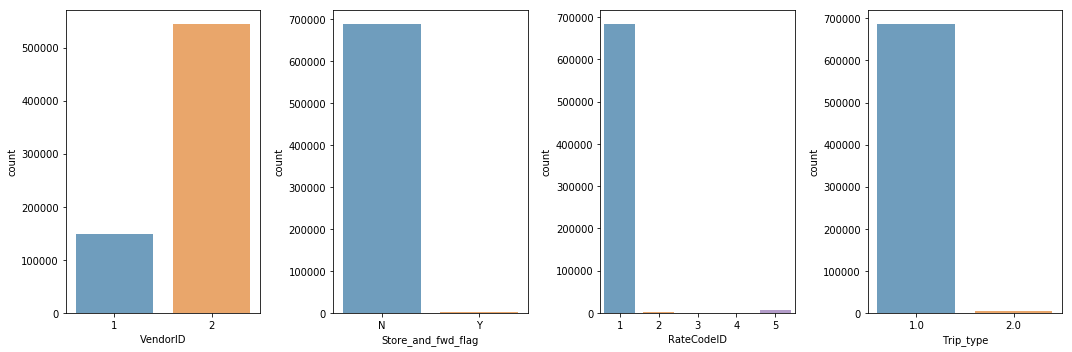

In [54]:
categorical_columns = ["VendorID", "Store_and_fwd_flag", "RateCodeID", "Trip_type"]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, ax in enumerate(fig.axes):
    if i < len(q4_data[categorical_columns].columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels())
        sns.countplot(x=q4_data[categorical_columns].columns[i], alpha=0.7, data=q4_data[categorical_columns], ax=ax)
fig.tight_layout()

The levels are all documented. The "Store_and_fwd_flag", "RateCodeID", and "Trip_type" are very skewed. In this case, keep these 3 skewed categorical variables and let the algorithm to select variables later. 

Make a copy of the cleaned data.

In [83]:
q4_data_cleaned = q4_data.copy()

### **- Feature Engineering**

- **Parse pickup and dropoff times and create more time features including hour_of_day, day_of_week, day_of_month, duration_of_trip in hours, and avg_speed in mph.**

Create a functon to parse the pickup and dropoff times and create new time-related variables. <font color=red>**Dropoff time was used to represent the time of a trip**</font>. 

In [56]:
def datetime_parser(df_row):
    pickup_obj = datetime.strptime(df_row["lpep_pickup_datetime"], "%Y-%m-%d %H:%M:%S")
    dropoff_obj = datetime.strptime(df_row["Lpep_dropoff_datetime"], "%Y-%m-%d %H:%M:%S")
    hour_of_day = dropoff_obj.hour
    day_of_week = dropoff_obj.weekday() + 1 # It indexes Monday as 0. Need to add 1. 
    day_of_month = dropoff_obj.day
    duration_of_trip = ((dropoff_obj - pickup_obj)/timedelta(minutes=1))/60 # calculate the duration in hours
    avg_speed = df_row["Trip_distance"]/duration_of_trip # get speed in mph

    return (hour_of_day, day_of_week, day_of_month, duration_of_trip, avg_speed)

In [84]:
time_columns = ["Hour_of_day","Day_of_week", "Day_of_month", "Duration_of_trip", "Avg_speed"]
q4_data_cleaned[time_columns] = q4_data_cleaned.apply(lambda row: pd.Series(datetime_parser(row)), axis=1)
q4_data_cleaned.drop(["lpep_pickup_datetime","Lpep_dropoff_datetime"], axis=1, inplace=True)
q4_data_cleaned.head()

,VendorID,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tolls_amount,improvement_surcharge,Trip_type,Tip_percent,Hour_of_day,Day_of_week,Day_of_month,Duration_of_trip,Avg_speed
2,2,N,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,0.5,0.0,0.3,1.0,8.620690,0.0,2.0,1.0,0.042778,13.792208
5,2,N,1,-73.945297,40.808186,-73.937668,40.821198,1,1.07,5.5,0.5,0.5,0.0,0.3,1.0,16.666667,0.0,2.0,1.0,0.078056,13.708185
6,2,N,1,-73.890877,40.746426,-73.876923,40.756306,1,1.43,6.5,0.5,0.5,0.0,0.3,1.0,0.000000,0.0,2.0,1.0,0.082778,17.275168
8,2,N,1,-73.963150,40.693829,-73.956787,40.680531,1,1.33,6.0,0.5,0.5,0.0,0.3,1.0,16.666667,0.0,2.0,1.0,0.078889,16.859155
11,2,N,1,-73.905540,40.772526,-73.895363,40.768963,1,0.70,4.0,0.5,0.5,0.0,0.3,1.0,16.666667,0.0,2.0,1.0,0.035000,20.000000


- **Transform the longitude and latitude of pickup and dropoff into directions.**

Latitude and logitude are spherical coordinates and cannot be directly used as continuous variables in a machine learning model because they are not ordinal. They provide the relative positions of 2 points and it's possible to get the direction of the dropoff point relative to the pickup point.

The following function to get direction is modified based on [Stackoverflow](https://stackoverflow.com/a/22740092/4252941). The directions are grouped into 4 quadrants.

In [81]:
def get_direction(df_row):
    # dropoff point
    x1 = np.deg2rad(df_row["Dropoff_latitude"]);
    y1 = np.deg2rad(df_row["Dropoff_longitude"]);
    # pickup point
    x2 = np.deg2rad(df_row["Pickup_latitude"]);
    y2 = np.deg2rad(df_row["Pickup_longitude"]);

    radians = math.atan2((y1 - y2), (x1 - x2));
    compassReading = radians * (180 / math.pi);
    # NE, SE, SW, NW
    quadrantIndictor = [0, 0, 0, 0];
    coordIndex = round(compassReading / 90);
    if coordIndex < 0:
        coordIndex = coordIndex + 4
    
    if coordIndex == 4:
        coordIndex = 0
        
    quadrantIndictor[coordIndex] = 1
    
    return tuple(quadrantIndictor) 

In [85]:
quadrantNames = ["NE", "SE", "SW", "NW"]
q4_data_cleaned[quadrantNames] = q4_data_cleaned.apply(lambda row: pd.Series(get_direction(row)), axis=1)
q4_data_cleaned.drop(["Pickup_longitude","Pickup_latitude", "Dropoff_longitude", "Dropoff_latitude"], axis=1, inplace=True)
q4_data_cleaned.head()

,VendorID,Store_and_fwd_flag,RateCodeID,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tolls_amount,improvement_surcharge,Trip_type,Tip_percent,Hour_of_day,Day_of_week,Day_of_month,Duration_of_trip,Avg_speed,NE,SE,SW,NW
2,2,N,1,1,0.59,4.0,0.5,0.5,0.0,0.3,1.0,8.620690,0.0,2.0,1.0,0.042778,13.792208,0,1,0,0
5,2,N,1,1,1.07,5.5,0.5,0.5,0.0,0.3,1.0,16.666667,0.0,2.0,1.0,0.078056,13.708185,1,0,0,0
6,2,N,1,1,1.43,6.5,0.5,0.5,0.0,0.3,1.0,0.000000,0.0,2.0,1.0,0.082778,17.275168,0,1,0,0
8,2,N,1,1,1.33,6.0,0.5,0.5,0.0,0.3,1.0,16.666667,0.0,2.0,1.0,0.078889,16.859155,0,0,1,0
11,2,N,1,1,0.70,4.0,0.5,0.5,0.0,0.3,1.0,16.666667,0.0,2.0,1.0,0.035000,20.000000,0,1,0,0


<font color=red>**If I have enough time, I can create more features. It is possible to use the latitude and longitude to map with Census Bureau's data to get aggregated information about the socioeconomic factors (income, education level, occupation) and demographics data. It is also possible to map the location and time with historical weather data or local events (games, concerts, memorial events) to get more variables.**</font>

- **One-hot encoding the categorical variables.**

In [88]:
cat_columns = ["VendorID", "Store_and_fwd_flag", "RateCodeID", "Trip_type"]
q4_data_cleaned = pd.get_dummies(q4_data_cleaned, columns=cat_columns, drop_first=False)
q4_data_cleaned.head()

,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tolls_amount,improvement_surcharge,Tip_percent,Hour_of_day,Day_of_week,Day_of_month,Duration_of_trip,Avg_speed,NE,SE,SW,NW,VendorID_1,VendorID_2,Store_and_fwd_flag_N,Store_and_fwd_flag_Y,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,Trip_type_1.0,Trip_type_2.0
2,1,0.59,4.0,0.5,0.5,0.0,0.3,8.620690,0.0,2.0,1.0,0.042778,13.792208,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0
5,1,1.07,5.5,0.5,0.5,0.0,0.3,16.666667,0.0,2.0,1.0,0.078056,13.708185,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0
6,1,1.43,6.5,0.5,0.5,0.0,0.3,0.000000,0.0,2.0,1.0,0.082778,17.275168,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0
8,1,1.33,6.0,0.5,0.5,0.0,0.3,16.666667,0.0,2.0,1.0,0.078889,16.859155,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0
11,1,0.70,4.0,0.5,0.5,0.0,0.3,16.666667,0.0,2.0,1.0,0.035000,20.000000,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0


- **Check distributions of the derived numerical attributes**

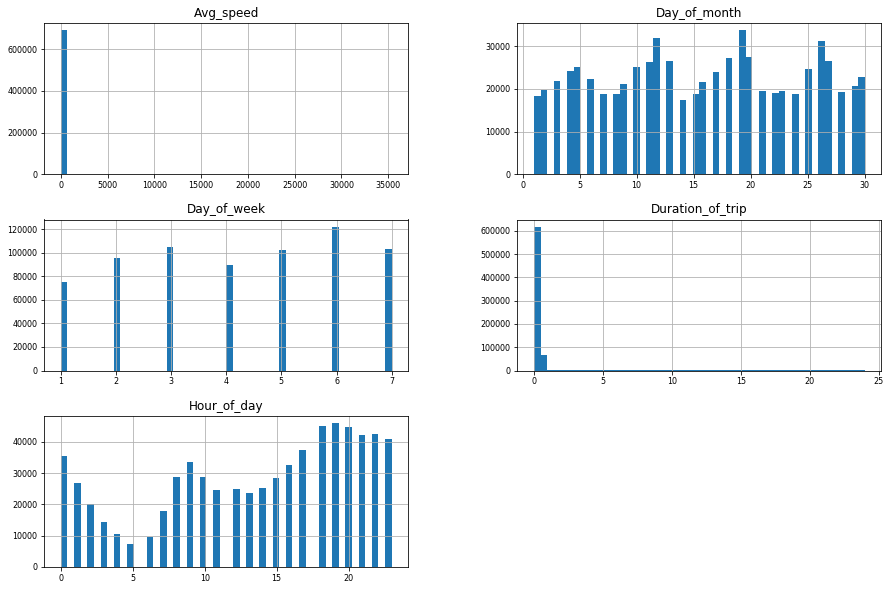

In [89]:
q4_data_cleaned[time_columns].hist(figsize=(15,10), bins=50, xlabelsize=8, ylabelsize=8);

There are several findings:

1. Some trips have an average speed far exceeding 65 mph, which is the speed limit of freeways and interstates in [New York](https://www.yourmechanic.com/article/new-york-speed-limits-laws-and-fines-by-valerie-mellema). There must be recording errors in the data of trip distance or time. These trips need to be removed. 
2. The frequency of trips has a weekly pattern. There are 4 major spikes of trip number in the "day_of_month" attribute. These 4 spikes correspond to Saturdays in September 2015 (9/5, 9/12, 9/19, 9/26). The distribution of "day_of_week" attribute has further confirmed this finding. Most people like to hang out on Saturday because they are free of work and have Sunday as backup. Another reason is that it is harder to finding a parking spot in NYC on weekends. Therefore, many people chose to take taxi. 
3. The frequency of trips has an hourly pattern. There is a spike in 8-9 am and another spike in 6-7 pm. This makes sense because these are the time people go to work and return from work. Some people will take taxi to go to work/home. 
4. There are outliers in "duration_of_trip". The longest trip time is 24 hours. Although it's possible to have a taxi trip this long but this cannot represent most trips. These outliers should be removed. 

More than 99% of transactions are below 80 mph and shorter than 5 hours. Use these 2 criterion to remove outliers.

In [86]:
len(q4_data_cleaned[q4_data_cleaned["Avg_speed"]<=80])/len(q4_data_cleaned)

0.9990209349276041

In [87]:
len(q4_data_cleaned[q4_data_cleaned["Duration_of_trip"]<=5])/len(q4_data_cleaned)

0.9951191364559291

Remove the outliers in average speed and duration of trip.

In [90]:
q4_data_cleaned = q4_data_cleaned[(q4_data_cleaned["Avg_speed"]<=80)&(q4_data_cleaned["Duration_of_trip"]<=5)]
q4_data_cleaned.shape

(687424, 28)

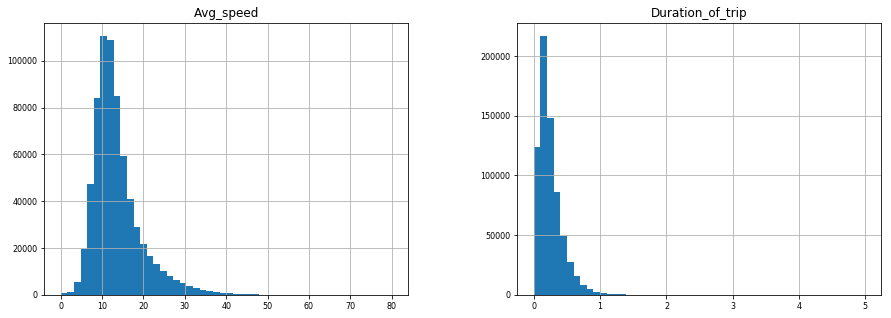

In [91]:
q4_data_cleaned[["Avg_speed","Duration_of_trip"]].hist(figsize=(15,5), bins=50, xlabelsize=8, ylabelsize=8);

After removing the outliers, the average speedn and duration of trip look much better.

In [92]:
q4_data_preprocessed = q4_data_cleaned.copy()

In [93]:
print("The preprocessed data has %s samples and %s variables." % q4_data_preprocessed.shape)

The preprocessed data has 687424 samples and 28 variables.


### - Feature Reduction

- **Check pairwise correlations**

This method will detect colinearity problems between a pair of variables. First plot the correlation matrix.

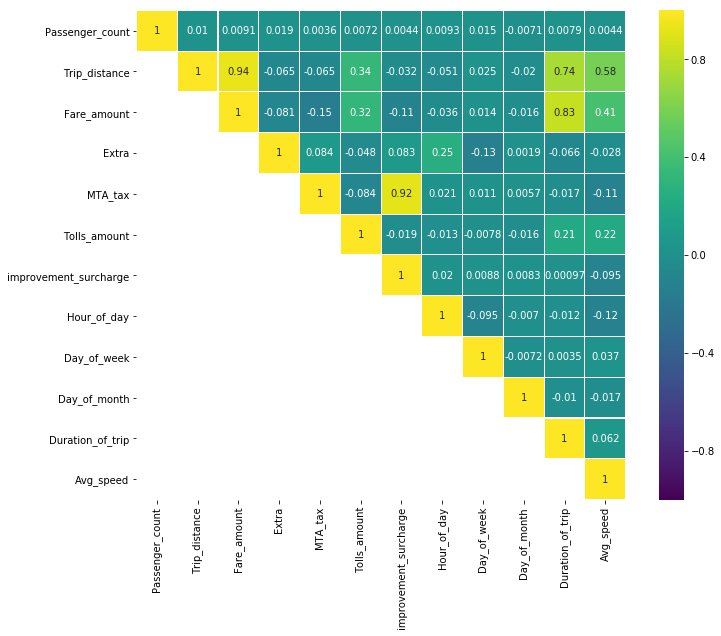

In [95]:
numerical_columns = ['Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount', 
                     'improvement_surcharge', 'Hour_of_day', 'Day_of_week', 'Day_of_month', 
                     'Duration_of_trip', 'Avg_speed']

# get the correlation matrix
corr_matrix = q4_data_preprocessed[numerical_columns].corr()
# plot the upper triangle to reduce redundancy
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape)).astype(np.bool))
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, square=True, annot=True);

Only explore variable pairs with strong correlations (|r| ≥ 0.7). 

In [96]:
# convert the matrix into a list
corr_list = corr_matrix.stack().reset_index()
corr_list.columns = ['Variable_1','Variable_2','r']
# only keep variable pairs with strong correlations (|r| ≥ 0.7)
strong_corr = corr_list[((corr_list["r"] >= 0.7) | (corr_list["r"] <= -0.7)) & (corr_list["Variable_1"] != corr_list["Variable_2"])]
strong_corr = strong_corr.sort_values(["r"], ascending=False)
strong_corr.reset_index(drop=True,inplace=True)
strong_corr

,Variable_1,Variable_2,r
0,Trip_distance,Fare_amount,0.936696
1,MTA_tax,improvement_surcharge,0.921393
2,Fare_amount,Duration_of_trip,0.827711
3,Trip_distance,Duration_of_trip,0.735778


These correlations are actually expected. The longer trip distance will have longer duration and higher fare amount. The MTA tax and improvement surchage are accessed by rules. A trip with higher MTA tax needs to pay more improvement surcharge. Based on r, we need to drop "Fare_amount", "Duration_of_trip", and "MTA_tax". 

In [97]:
correlation_columns = ["Fare_amount", "Duration_of_trip", "MTA_tax"]
q4_data_preprocessed.drop(correlation_columns, axis=1, inplace=True)
numerical_columns = list(set(numerical_columns) - set(correlation_columns))

- **Check variance inflation factor (VIF) among multiple numerical variables**

This method can detect multicolinearity among multiple numerical variables. VIF > 10 indicates strong multicolinearity exists. The dropping of variables with high VIF is an iterative process. Everytime a varible is dropped, the VIF calculation will be preformed again. The following function to drop variables with high VIF is based on [StackExchange](https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python/253620#253620) with some modifications.

In [98]:
def drop_vif(df, thresh=10):
    col_names = df.columns
    variable_indices = np.arange(df.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = df[col_names[variable_indices]].values
        vif = [variance_inflation_factor(c, i) for i in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('Dropping \'' + df[col_names[variable_indices]].columns[maxloc] + '\' with VIF = ', max(vif))
            variable_indices = np.delete(variable_indices, maxloc)
            dropped=True
    
    print("Done!")

In [99]:
drop_vif(q4_data_preprocessed[numerical_columns])

Dropping 'improvement_surcharge' with VIF =  18.956710501938836
Done!


Drop "improvement_surcharge".

In [100]:
multicolinearity_columns = ['improvement_surcharge']
q4_data_preprocessed.drop(multicolinearity_columns, axis=1, inplace=True)
numerical_columns = list(set(numerical_columns) - set(multicolinearity_columns))

Make a copy of the final data set. 

In [101]:
q4_data_final = q4_data_preprocessed.copy()
print("The final data set has %s samples and %s variables." % q4_data_final.shape)

The final data set has 687424 samples and 24 variables.


### - Model Building and Evaluation

We are interested in predicting the tip as a percentage of the total fare. This is a <font color=red>**regression problem**</font>. The data contains both numerical variables and dummy variables. In this project, the gradient tree boosting algorithm <font color=red>**XGBoost**</font> was used to build the regression model. The XGBoost algorithm tries to minimize the prediction bias and generally have good performance in regresssions and classifications. It's a long-term winner in many Kaggle competitions and can even beat deep learning in many settings. Compared to GLMs and neural networks, tree-based models are <font color=red>**insensitive to multicollinearity issue and don't require feature normalization**</font>. 

Although XGBoost is insensitive to multicollinearity, the variables with multicollinearity were removed in the previous step to improve the training speed. 

- **Split the data into a training set and a test set (8:2).**

In [184]:
X = q4_data_final[['Passenger_count', 'Trip_distance', 'Extra', 'Tolls_amount', 'Hour_of_day', 'Day_of_week', 
    'Day_of_month', 'Avg_speed', 'NE', 'SE', 'SW', 'NW', 'VendorID_1', 'VendorID_2', 'Store_and_fwd_flag_N', 
    'Store_and_fwd_flag_Y', 'RateCodeID_1', 'RateCodeID_2', 'RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5', 
    'Trip_type_1.0', 'Trip_type_2.0']].values
y = q4_data_final['Tip_percent'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

- **Hyperparameter tuning with the training data**

XGBoost has many hyperparameters to tune. To save time, the hyperparameters were tuned in groups using a stepwise grid search approach with the training data. The following stepwise grid search function is modified base on [GitHub](https://github.com/YaronBlinder/MIMIC-III_readmission/blob/master/notebooks/3_xgboosting.ipynb).

In [196]:
def xgb_hyperparameter_tuning(X_train, y_train, initial_estimator, metric, cv=5):
    
    param_test0 = {
     'n_estimators':range(50,250,10)
    }
    print('Performing hyperparamter optimization step 0')
    gsearch0 = GridSearchCV(estimator = initial_estimator, 
     param_grid = param_test0, scoring=metric,n_jobs=4,iid=False, cv=cv)
    gsearch0.fit(X_train,y_train)
    print(gsearch0.best_params_, gsearch0.best_score_)

    param_test1 = {
     'max_depth':range(1,10),
     'min_child_weight':range(1,10)
    }
    print('Performing hyperparamter optimization step 1')
    gsearch1 = GridSearchCV(estimator = gsearch0.best_estimator_,
     param_grid = param_test1, scoring=metric,n_jobs=4,iid=False, cv=cv)
    gsearch1.fit(X_train,y_train)
    print(gsearch1.best_params_, gsearch1.best_score_)

    max_d = gsearch1.best_params_['max_depth']
    min_c = gsearch1.best_params_['min_child_weight']

    param_test2 = {
     'gamma':[i/10. for i in range(0,5)]
    }
    print('Performing hyperparamter optimization step 2')
    gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, 
     param_grid = param_test2, scoring=metric,n_jobs=4,iid=False, cv=cv)
    gsearch2.fit(X_train,y_train)
    print(gsearch2.best_params_, gsearch2.best_score_)

    param_test3 = {
        'subsample':[i/10.0 for i in range(1,10)],
        'colsample_bytree':[i/10.0 for i in range(1,10)]
    }
    print('Performing hyperparamter optimization step 3')
    gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_, 
     param_grid = param_test3, scoring=metric,n_jobs=4,iid=False, cv=cv)
    gsearch3.fit(X_train,y_train)
    print(gsearch3.best_params_, gsearch3.best_score_)

    param_test4 = {
        'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]
    }
    print('Performing hyperparamter optimization step 4')
    gsearch4 = GridSearchCV(estimator = gsearch3.best_estimator_, 
     param_grid = param_test4, scoring=metric,n_jobs=4,iid=False, cv=cv)
    gsearch4.fit(X_train,y_train)
    print(gsearch4.best_params_, gsearch4.best_score_)

    alpha = gsearch4.best_params_['reg_alpha']
    if alpha != 0:
        param_test4b = {
            'reg_alpha':[0.1*alpha, 0.25*alpha, 0.5*alpha, alpha, 2.5*alpha, 5*alpha, 10*alpha]
        }
        print('Performing hyperparamter optimization step 4b')
        gsearch4b = GridSearchCV(estimator = gsearch4.best_estimator_, 
         param_grid = param_test4b, scoring=metric,n_jobs=4,iid=False, cv=cv)
        gsearch4b.fit(X_train,y_train)
        print(gsearch4b.best_params_, gsearch4.best_score_)
        print('\nParameter optimization finished!')
        xgb_opt = gsearch4b.best_estimator_
        xgb_opt
    else:
        xgb_opt = gsearch4.best_estimator_
        xgb_opt

    return xgb_opt
    print(xgb_opt)

Tune hyperparameters on the training data.

<font color=red>**Warning**: This step took more than 10 hours to finish on my laptop (macOS 10.14.1, 2.7 GHz i7, 16 GB LPDDR3 Memory, Radeon Pro 455 2G GPU)</font>.

In [199]:
xgb_opt = xgb_hyperparameter_tuning(X_train, y_train, XGBRegressor(), "neg_mean_squared_error")

Performing hyperparamter optimization step 0
{'n_estimators': 240} -51.45322308687465
Performing hyperparamter optimization step 1
{'max_depth': 4, 'min_child_weight': 3} -51.40437838300259
Performing hyperparamter optimization step 2
{'gamma': 0.0} -51.40437838300259
Performing hyperparamter optimization step 3
{'colsample_bytree': 0.8, 'subsample': 0.9} -51.43110168230665
Performing hyperparamter optimization step 4
{'reg_alpha': 10} -51.41115365188216
Performing hyperparamter optimization step 4b
{'reg_alpha': 100} -51.41115365188216

Parameter optimization finished!


In [206]:
print(xgb_opt)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
       n_estimators=240, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=100, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)


In [102]:
print("""The optimized hyperparameters are: base_score=0.5, booster='gbtree', colsample_bylevel=1, 
    colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=4, min_child_weight=3, 
    missing=None, n_estimators=240, n_jobs=1, nthread=None, objective='reg:linear', random_state=0, 
    reg_alpha=100, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.9""")

The optimized hyperparameters are: base_score=0.5, booster='gbtree', colsample_bylevel=1, 
    colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=4, min_child_weight=3, 
    missing=None, n_estimators=240, n_jobs=1, nthread=None, objective='reg:linear', random_state=0, 
    reg_alpha=100, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.9


Save the optimized model into a pickle file.

In [201]:
with open ("xgb_opt.pkl", "wb") as f:
    pickle.dump(xgb_opt, f)

- **Model performance evaluation with the test data.** 

The root mean squared error (rmse) was used as the metric to evaluate the regression model. The optimized model's rmse in the training data is sqrt(51.41115365188216) = 7.170157157. Now check if the rmse in the test set is similar.

In [205]:
y_pred = xgb_opt.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print("The optimized XGBoost regression model has achieved a rmse of", rmse)

The optimized XGBoost regression model has achieved a rmse of 7.2047067165677605


The rmse in the test set is very close to the training set. This indicates the model can <font color=red>**generalize well**</font> to unknown data. The rmse has the same unit as the target (percentage). This result indicate that the model can give an estimate of the tip percentage with a standard deviation of 7.2. 

- **Model interpretation.**

The [feature importance](https://dl.acm.org/citation.cfm?id=2939785) measures how useful a variable is in the prediction. It's calculated for a single decision tree by the amount that each variable's split improves the performance measure, weighted by the number of observations the node is responsible for. Then the feature importances are averaged across all the decision trees in the ensemble. All the feature importances will sum up to 1 with a higher value indicating a higher importance. 

Get the feature importances from the XGBoost regression model and plot them. 

In [138]:
fscore = xgb_opt.feature_importances_
feature_name = ['Passenger_count', 'Trip_distance', 'Extra', 'Tolls_amount', 'Hour_of_day', 'Day_of_week', 
    'Day_of_month', 'Avg_speed', 'NE', 'SE', 'SW', 'NW', 'VendorID_1', 'VendorID_2', 'Store_and_fwd_flag_N', 
    'Store_and_fwd_flag_Y', 'RateCodeID_1', 'RateCodeID_2', 'RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5', 
    'Trip_type_1.0', 'Trip_type_2.0']

fscore_df = pd.DataFrame(list(zip(feature_name, fscore)), columns=["Feature", "Importance"])
fscore_df.sort_values(["Importance"], ascending=False, inplace=True)
fscore_df

,Feature,Importance
7,Avg_speed,0.255530
1,Trip_distance,0.221769
4,Hour_of_day,0.127765
6,Day_of_month,0.081199
5,Day_of_week,0.054715
2,Extra,0.032887
0,Passenger_count,0.032305
8,NE,0.030559
10,SW,0.027357
3,Tolls_amount,0.024156


Plot the feature importance.

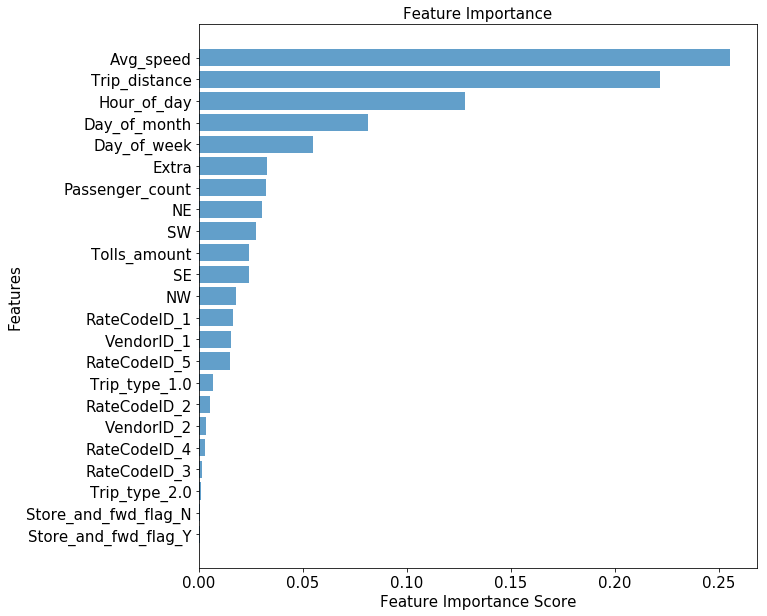

In [141]:
pos = range(len(fscore_df))
plt.figure(figsize=(10, 10))
plt.barh(pos, width=fscore_df["Importance"].values, align="center", alpha=0.7)
plt.yticks(pos, fscore_df["Feature"].values, fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.xlabel("Feature Importance Score", fontsize=15)
plt.title("Feature Importance", fontsize=15)
plt.gca().invert_yaxis()
plt.show()

<font color=red>**The average speed, trip distance, hour of day, day of month, day of week are important predictors in this model**</font>. This actually makes sense because the time and trip distance can largely impact the percentage of tip. For example, the tip at night are normally higher than daytime. 

To better understand their relationships, plot the tip percentage versus the average speed, trip distance, hour of day, day of month, and day of week.

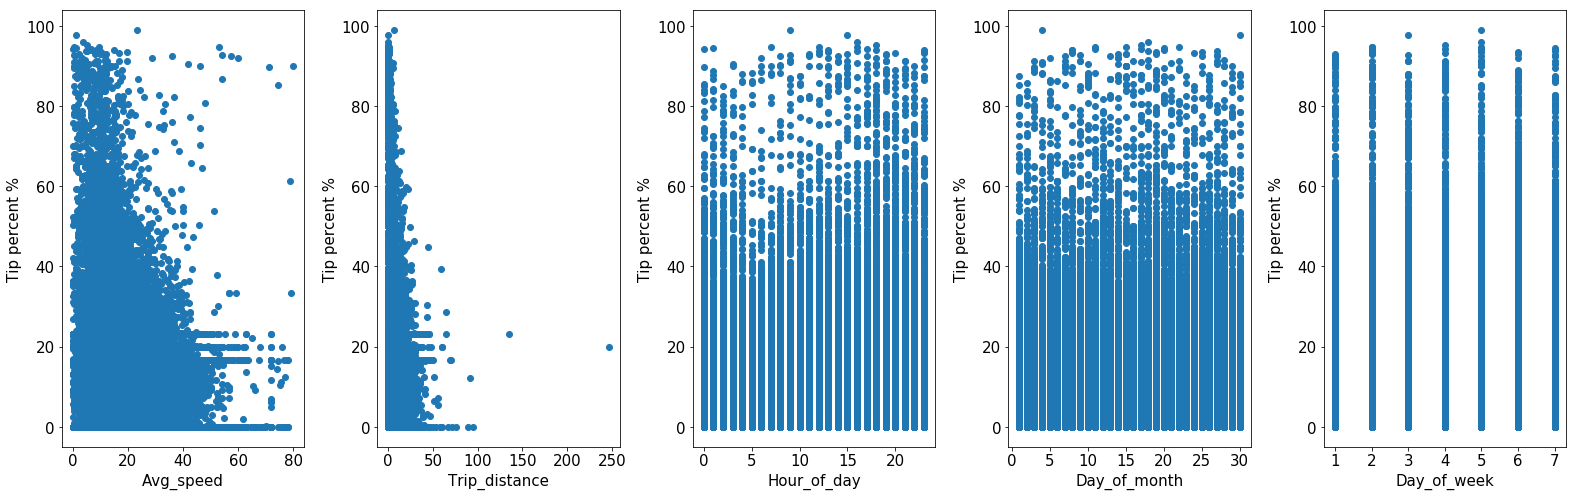

In [143]:
plt.figure(figsize=(22, 7))

important_columns = ["Avg_speed","Trip_distance","Hour_of_day","Day_of_month","Day_of_week"]
for i in range(len(important_columns)):
    plt.subplot(1,5,i+1)
    plt.scatter(q4_data_final[important_columns[i]], q4_data_final["Tip_percent"])
    plt.xlabel(important_columns[i], fontsize=15)
    plt.ylabel("Tip percent %", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.tight_layout()

It can be seen that the average speed and trip distance are negetively associated with the tip percent. The possible reasons are:
- If the traffic is slow, the passengers are more likely to have conversations with taxi drivers. A good conversation can often result in a higher tip amount. 
- Many passengers will tip a fixed amount (e.g., 2 dollars) instead of using percentage. For short trip distance, the fare is relatively low. Therefore the tip percentage is high. 

The tip percentage seems higher in the afternoon than in the moring. This is very common in the United States. 

The relationships between tip percentage and day of month or day of week are hard to observe in the 2D scatter plots. This indicates that they impact the tip percentage in a non-linear way and/or interact with other variables.

<h1><center>Question 5 - Option A: Distributions</center></h1>

**Summary:**

In this question, one way ANOVA was used to test if the average speeds are the same in all weeks of September. The result indicated that the average speeds are not the same for all weeks. The Tukey Post Hoc test was used to test the pairwise difference. Similar methods were used to test the average speed in different hours of a day. The result indicated most the average speeds are different for most pairs of hours. Different visualizations were created to help analyze the data and support hypotheses. The methods and major findings are summarized as follows. 

1. The derived variable of the average speed in mph was built through divding the trip distance by the duration of the trip. 
2. The trips with a speed faster than 80 mph were treated as outliers and were removed. The speed limit for freeways and interstates in New York is 65 mph. A buffer of 15 mph was used to account for drivers who violated the traffic rule. 
3. The trip time was parsed into different time elements, including ** <font color=red>hour_of_day, day_of_week, day_of_month, week, duration_of_trip in hours, avg_speed in mph. The dropoff time was used to get most time elements.**</font> 
4. There are 5 weeks in 2015 September if assuming Monday as the start of a week: Week 1: 9/1 - 9/6, Week 2: 9/7 - 9/13, Week 3: 9/14 - 9/20, Week 4: 9/21 - 9/27, Week 5: 9/28 - 9/30.
5. <font color=red>**All the tests used a 95% condidence level**</font>. 
6. <font color=red>**One way ANOVA**</font> was used to test the difference in mean speeds of the 5 weeks. The result indicated that not all of them were the same. To test which pair(s) of the mean speeds were different, the <font color=red>**Tukey Post Hoc test**</font> was performed. The result indicated that all of them were significantly different from each other except that week 2 and week 3 were not significantly different. There are many possible reasons about the difference, such as local event, rush hour, and weather. 
7. One way ANOVA and Tukey Post Hoc tests were also used to test the difference in mean speeds of the 24 hours in a day. Most of them were significantly different. The differnce in speed within a day is normally influnced by rush hour. 

### 5.1 Build a derived variable representing the average speed over the course of a trip.

Only keep variables required for this analysis.

In [144]:
q5_data = raw_data[['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Trip_distance']]
q5_data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Trip_distance
0,2015-09-01 00:02:34,2015-09-01 00:02:38,0.00
1,2015-09-01 00:04:20,2015-09-01 00:04:24,0.00
2,2015-09-01 00:01:50,2015-09-01 00:04:24,0.59
3,2015-09-01 00:02:36,2015-09-01 00:06:42,0.74
4,2015-09-01 00:00:14,2015-09-01 00:04:20,0.61


This data has errors in time and trip distance. Remove trips with dropoff time ≤ pickup time or trip distance ≤ 0.

In [145]:
q5_data = q5_data[(q5_data["lpep_pickup_datetime"]<q5_data["Lpep_dropoff_datetime"])&(q5_data["Trip_distance"]>0)]
print("%s trips with errors have been removed from the original data, which has %s trips." % (len(raw_data)-len(q5_data), len(raw_data)))

20735 trips with errors have been removed from the original data, which has 1494926 trips.


Define a new datetime parser function to parse pickup and dropoff datetimes into ** <font color=red>hour_of_day, day_of_week, day_of_month, week, duration_of_trip in hours, avg_speed in mph. The dropoff time was used to get most time elements of the trip.**</font> The function to calculate week of month is modified based on [Stackoverflow](https://stackoverflow.com/questions/3806473/python-week-number-of-the-month).

In [147]:
# Use calendar day to divide 2015 September into the following 5 weeks. Assuming a week starts from Monday. 
# First week: Sep 1st to Sep 6th
# Second week: Sep 7th to Sep 13th
# Third week: Sep 14th to Sep 20th
# Fourth week: Sep 21th to Sep 27th
# Fifth week: Sep 28th to Sep 30th

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(math.ceil(adjusted_dom/7.0))

def datetime_parser2(df_row):
    pickup_obj = datetime.strptime(df_row["lpep_pickup_datetime"], "%Y-%m-%d %H:%M:%S")
    dropoff_obj = datetime.strptime(df_row["Lpep_dropoff_datetime"], "%Y-%m-%d %H:%M:%S")
    dropoff_hour = dropoff_obj.hour
    dropoff_day_of_week = dropoff_obj.weekday() + 1
    dropoff_day_of_month = dropoff_obj.day
    dropoff_week_of_month = week_of_month(pickup_obj)

    duration_of_trip = ((dropoff_obj - pickup_obj)/timedelta(minutes=1))/60 # calculate the duration in hours
    avg_speed = df_row["Trip_distance"]/duration_of_trip # get speed in mph

    return (dropoff_hour, dropoff_day_of_week, dropoff_day_of_month, dropoff_week_of_month, duration_of_trip, avg_speed)

In [148]:
time_columns2 = ["Dropoff_hour","Dropoff_day_of_week","Dropoff_day_of_month","Dropoff_week_of_month",
                 "Duration_of_trip", "Avg_speed"]

In [149]:
q5_data[time_columns2] = q5_data.apply(lambda row: pd.Series(datetime_parser2(row)), axis=1)
q5_data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Trip_distance,Dropoff_hour,Dropoff_day_of_week,Dropoff_day_of_month,Dropoff_week_of_month,Duration_of_trip,Avg_speed
2,2015-09-01 00:01:50,2015-09-01 00:04:24,0.59,0.0,2.0,1.0,1.0,0.042778,13.792208
3,2015-09-01 00:02:36,2015-09-01 00:06:42,0.74,0.0,2.0,1.0,1.0,0.068333,10.829268
4,2015-09-01 00:00:14,2015-09-01 00:04:20,0.61,0.0,2.0,1.0,1.0,0.068333,8.926829
5,2015-09-01 00:00:39,2015-09-01 00:05:20,1.07,0.0,2.0,1.0,1.0,0.078056,13.708185
6,2015-09-01 00:00:52,2015-09-01 00:05:50,1.43,0.0,2.0,1.0,1.0,0.082778,17.275168


Based on the data cleaning step in question 4, many trips have an average speed faster than 80 mph, which should be errors in the data. Remove trips with average speed faster than 80 mph. 

In [150]:
q5_data_cleaned = q5_data[q5_data["Avg_speed"]<=80]
print("%s trips with an average speed faster than 80 mph have been removed." % (len(q5_data)-len(q5_data_cleaned)))

3123 trips with an average speed faster than 80 mph have been removed.


The distribution of average trip speed looks better after removing outliers.

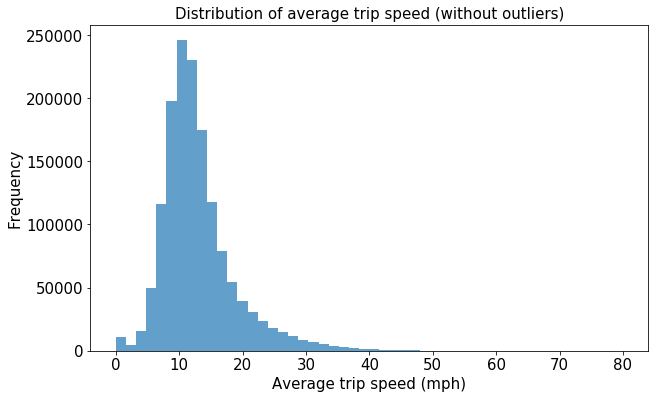

In [151]:
plt.figure(figsize=(10, 6))
plt.hist(q5_data_cleaned["Avg_speed"], alpha=0.7, bins=50)
plt.title("Distribution of average trip speed (without outliers)", fontsize=15)
plt.xlabel("Average trip speed (mph)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 5.2 Perform a test to determine if the average trip speeds are materially the same in all weeks of September.

First plot the histogram of the average trip speed versus the week of dropoff. 

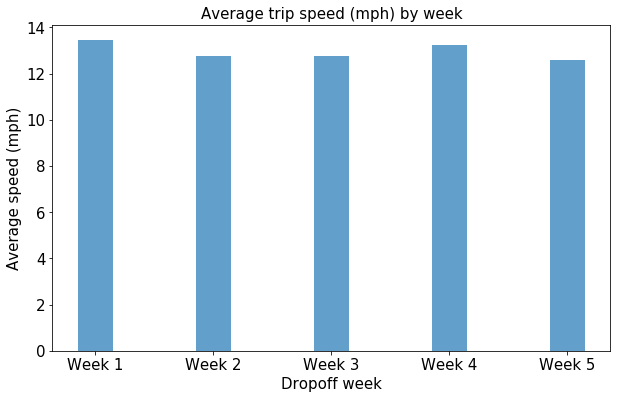

In [152]:
avg_speed_week = q5_data_cleaned[["Avg_speed","Dropoff_week_of_month"]].groupby("Dropoff_week_of_month").mean().reset_index()

pos = range(5)
plt.figure(figsize=(10, 6))
plt.bar(pos, height=avg_speed_week["Avg_speed"].values, align="center", alpha=0.7, width=0.3)
plt.xticks(pos, ["Week 1", "Week 2", "Week 3", "Week 4", "Week 5"], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dropoff week", fontsize=15)
plt.ylabel("Average speed (mph)", fontsize=15)
plt.title("Average trip speed (mph) by week", fontsize=15)
plt.show()

They look pretty close to each other. The differences between them need to be tested by a statistical method. <font color=red>**One way Analysis of Variance (ANOVA)**</font> is the most appropriate method. <font color=red>**95% significance level was used**</font>. 

First check the distribution of average speeds in the 5 weeks of September. It can be seen that the 5 distributions are very similar to each other and are gaussian-like. 

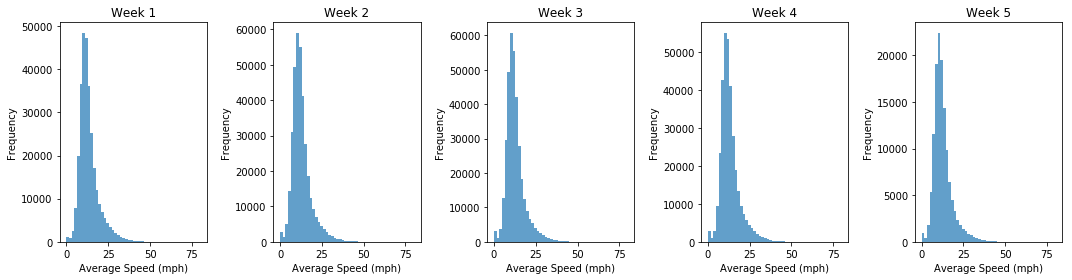

In [153]:
plt.figure(figsize=(15, 4))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.hist(q5_data_cleaned[q5_data_cleaned["Dropoff_week_of_month"]==i]["Avg_speed"].values, alpha=0.7, bins=50)
    plt.title("Week " + str(i))
    plt.xlabel("Average Speed (mph)")
    plt.ylabel("Frequency")
plt.tight_layout()

Check the number of trips in each week.

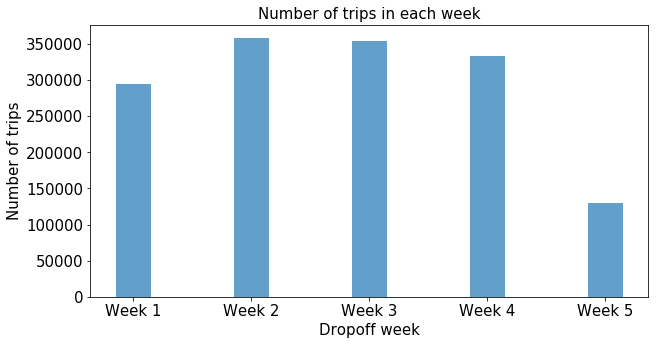

In [154]:
week_size = q5_data_cleaned[["Dropoff_week_of_month", "Avg_speed"]].groupby("Dropoff_week_of_month").count().reset_index()

pos = range(5)
plt.figure(figsize=(10, 5))
plt.bar(pos, week_size["Avg_speed"], align="center", alpha=0.7, width=0.3)
plt.xticks(pos, ["Week 1", "Week 2", "Week 3", "Week 4", "Week 5"], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dropoff week", fontsize=15)
plt.ylabel("Number of trips", fontsize=15)
plt.title("Number of trips in each week", fontsize=15)
plt.show()

The numbers of trips in the 5 weeks are different because the first week on 2015 September has 6 days and the last week only has 3 days. Assuming a week starts from Monday. 

ANOVA test of the mean trip speed in 5 weeks of September:

- H<sub>o</sub> : The mean speed is the same for all 5 weeks. ( μ<sub>1</sub> = μ<sub>2</sub> = μ<sub>3</sub> = μ<sub>4</sub> = μ<sub>5</sub> )
- H<sub>a</sub> : The mean speed is not the same for all 5 weeks.

In [159]:
model = ols('Avg_speed ~ C(Dropoff_week_of_month)', data=q5_data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                sum_sq         df            F  PR(>F)
C(Dropoff_week_of_month)  1.394304e+05        4.0  1034.471853     0.0
Residual                  4.956898e+07  1471063.0          NaN     NaN


<font color=red>**The result (p-value < 0.05) indicates that the mean speed is not the same for all 5 weeks.** </font>

Use <font color=red>**multiple comparison (Tukey Post Hoc) test** </font> to check which specific weeks are different. 

In [160]:
tukeyhsd = pairwise_tukeyhsd(q5_data_cleaned["Avg_speed"], q5_data_cleaned["Dropoff_week_of_month"])
print(tukeyhsd)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 1.0    2.0   -0.6822  -0.7216 -0.6428  True 
 1.0    3.0   -0.6712  -0.7107 -0.6318  True 
 1.0    4.0   -0.1974  -0.2374 -0.1574  True 
 1.0    5.0   -0.8599  -0.9126 -0.8072  True 
 2.0    3.0    0.011   -0.0265  0.0485 False 
 2.0    4.0    0.4848   0.4467  0.5229  True 
 2.0    5.0   -0.1777   -0.229 -0.1264  True 
 3.0    4.0    0.4739   0.4357  0.512   True 
 3.0    5.0   -0.1887   -0.24  -0.1373  True 
 4.0    5.0   -0.6625  -0.7143 -0.6107  True 
---------------------------------------------


From this result, we can see that <font color=red>**the average speeds are significantly different (p < 0.05) beween all pairs of weeks except week 2 and week 3.** </font>

**Why the average trip speeds were different?**

Trip speed can be influenced by several factors: <font color=red>**(1) Local events (2) Weather (3) Rush hour**. </font> By checking the [NYC events calendar](https://www.nycinsiderguide.com/new-york-city-events-september-2015) and [weather history](https://www.timeanddate.com/weather/usa/new-york/historic?month=9&year=2015) in 2015 September, I have found the possible answers to the following 3 questions.

**1. Why the average trip speed in week 2 is significantly slower than weeks 1 and 4?**

- The Monday of week 2 (Sep 7th) is <font color=red>**Labor Day**</font>. On Labor Day, schools and most offices will be closed. Students and most workers will get a day off from study or work. Most service providing businesses, such as restaurants and stores will open. A lot of people will go out for food or shopping. This may have made the traffic more congested. 

- The Friday (Sep 11th) of week 2 is the <font color=red>**14 Year Anniversary of 9/11/01**</font>. A lot of people will attend the 9/11 memorial events in NYC. This may have slowed down the traffic. 

- The <font color=red>**New York fashion week**</font> (Sep 10th - 17th) started on the Thursday of week 2. It may have caused a lot traffic. 

- It rained on Sep 10th. Raining can slow down traffic. 

**2. Why the average trip speed in week 3 is significantly slower than weeks 1 and 4?**

- In week 3, <font color=red>**Madonna had 3 concerts**</font>  in NYC (Sep 16th, 17th and 19th). This may have slowed down the traffic.  
- Most part of the <font color=red>**New York fashion week**</font>  (Sep 10th - 17th) were on week 3. It may have caused a lot traffic. 
- In week 3, there were 2 [<font color=red>**football games**</font>](https://www.nycfc.com/schedule?month=9&year=2015&club_options=Filters&op=Update&form_build_id=form-iaKop8u_-X17XNo7Dlp3Or1g0dc5wBkw3mFvZkW2les&form_id=mp7_schedule_hub_search_filters_form) in NYC: New York City FC VS. Toronto FC (Sep 16th), New York City FC VS. San Jose Earthquakes (Sep 19th). This may have caused a lot traffic.

**3. Why the average trip speed in week 5 is significantly slower than other 4 weeks?**

- According to the following figure (average trip speed in each day of September), <font color=red>**the traffic on weekends tend to be faster than workdays**</font>. There were only 3 days (Monday-Wednesday) on week 5 and therefore the average speed cannot be increased by weekends. 
- Another possible reason is that some companies have the "Work From Home Fridays" arrangements and this can potentially reduce the traffic volume and therefore can increase trip speed. Week 5 didn't have Friday.
- It rained on Sep 30th. Raining can slow down traffic.

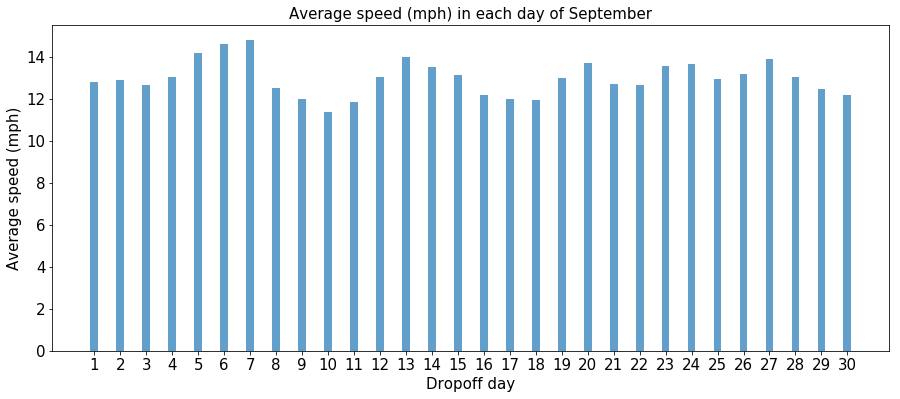

In [161]:
avg_speed_day_of_month = q5_data_cleaned[["Avg_speed","Dropoff_day_of_month"]].groupby("Dropoff_day_of_month").mean().reset_index()

pos = range(30)
xtick_labels = [str(i+1) for i in pos]
plt.figure(figsize=(15, 6))
plt.bar(pos, height=avg_speed_day_of_month["Avg_speed"].values, align="center", alpha=0.7, width=0.3)
plt.xticks(pos, xtick_labels, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dropoff day", fontsize=15)
plt.ylabel("Average speed (mph)", fontsize=15)
plt.title("Average speed (mph) in each day of September", fontsize=15)
plt.show()

### 5.3 Build up a hypothesis of average trip speed as a function of time of day.

First plot the histogram of the average trip speed versus the hour of dropoff. 

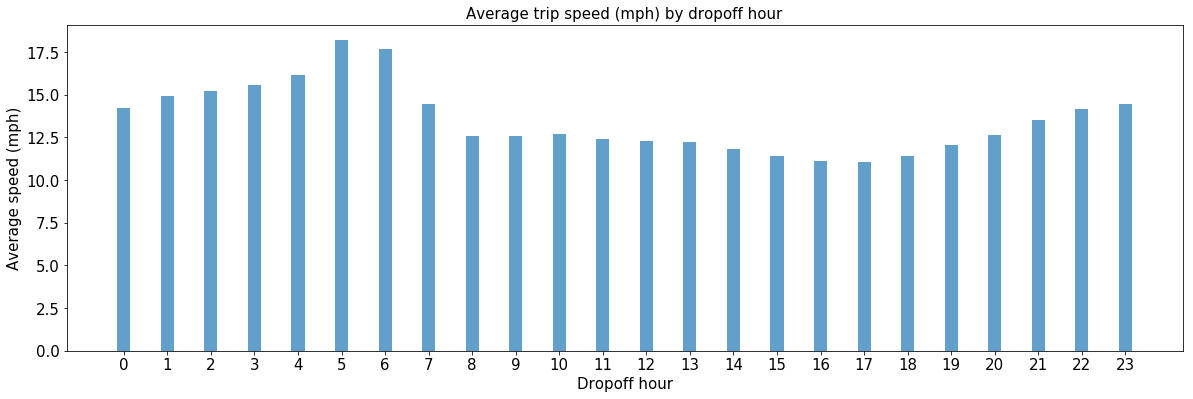

In [162]:
avg_speed_hour = q5_data_cleaned[["Avg_speed","Dropoff_hour"]].groupby("Dropoff_hour").mean().reset_index()

pos = range(24)
xtick_labels = [str(i) for i in pos]
plt.figure(figsize=(20, 6))
plt.bar(pos, height=avg_speed_hour["Avg_speed"].values, align="center", alpha=0.7, width=0.3)
plt.xticks(pos, xtick_labels, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Dropoff hour", fontsize=15)
plt.ylabel("Average speed (mph)", fontsize=15)
plt.title("Average trip speed (mph) by dropoff hour", fontsize=15)
plt.show()

From this bar chart, it can been that the average trip speed is <font color=red>**highest at 5-6 am and suddenly decreases from 7 am**</font>. This makes sense because most people will go to work and school at 7-8 am and the traffic will be congested at this time. A lot of people want to avoid this rush hour so that they will leave early at 5-6am. The average trip speed is the <font color=red>**lowest at 5 pm**</font> because most people will go back home from work or school at this time. This is another rush hour of the day.

Next, check if the differences in speeds at different hours are statistically significant with one way ANOVA. 

ANOVA test:

- H<sub>o</sub> : The mean speed is the same for all 24 hours.
- H<sub>a</sub> : The mean speed is not the same for all 24 hours.

In [164]:
model2 = ols('Avg_speed ~ C(Dropoff_hour)', data=q5_data_cleaned).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print(anova_table2)

                       sum_sq         df            F  PR(>F)
C(Dropoff_hour)  3.572139e+06       23.0  4952.035635     0.0
Residual         4.613627e+07  1471044.0          NaN     NaN


<font color=red>**The result (p-value < 0.05) indicates that the mean speed is not the same for all 24 hours**</font>.

Use multiple comparison (Tukey Post Hoc) test to check which specific hours are different. 

In [165]:
tukeyhsd2 = pairwise_tukeyhsd(q5_data_cleaned["Avg_speed"], q5_data_cleaned["Dropoff_hour"])
print(tukeyhsd2)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0     0.69    0.5752  0.8048  True 
 0.0    2.0    1.0185   0.8941  1.1428  True 
 0.0    3.0    1.3513   1.2144  1.4881  True 
 0.0    4.0    1.9234   1.7789  2.0679  True 
 0.0    5.0    3.9854   3.8128  4.158   True 
 0.0    6.0    3.4792   3.3147  3.6438  True 
 0.0    7.0    0.2215   0.0892  0.3538  True 
 0.0    8.0    -1.653  -1.7688 -1.5372  True 
 0.0    9.0   -1.6086  -1.7204 -1.4968  True 
 0.0    10.0  -1.5077  -1.6212 -1.3941  True 
 0.0    11.0  -1.8128  -1.9281 -1.6975  True 
 0.0    12.0  -1.9264  -2.0406 -1.8121  True 
 0.0    13.0  -1.9701  -2.0849 -1.8554  True 
 0.0    14.0  -2.3686   -2.48  -2.2572  True 
 0.0    15.0   -2.814   -2.922 -2.7059  True 
 0.0    16.0  -3.0961  -3.2018 -2.9904  True 
 0.0    17.0  -3.1752  -3.2785 -3.0718  True 
 0.0    18.0  -2.7771  -2.8775 -2.6767  True 
 0.0    19.0  -2.1658  -2.266

It can be seen that <font color=red>**most pairs of hours are significantly different (p < 0.05) in the average speed except the following pairs**</font>:
- 0 and 22
- 7 and 23 
- 8 and 9 
- 8 and 20 
- 9 and 10 
- 9 and 20 
- 10 and 20 
- 11 and 12 
- 12 and 13 
- 15 and 18
- 16 and 17

A major reason for the difference in hours is that some of the hours are rush hours. 

<h1><center>Conclusion</center></h1>

In this project, <font color=red>**data visualization, machine learning, and statistical inference**</font> were used to analyze the NYC Green Taxi data in September 2015. There are several<font color=red>** major findings**</font>.
- The trip distance follows a lognormal distribution.
- The mean trip distance is longer than the median trip distance when grouped by hour because the data is right-skewed.
- People like to take taxi to work or school in the morning. When they get back from work or school, they will choose a different method to go back home. 
- The trips have a weekly and hourly pattern. Saturday has the largest trip volume. On each day, 8-9 am and 6-7 pm have more trips.
- There are more dropoffs than pickups in the 3 airports. The average trip distance and fare of dropoffs are higher than pickups.
- The LGA airport has the largest number of pickups and dropoffs even though it is the smallest airport among the 3. One reason is that the average trip distance is the shortest in the 3 airports and the taxi fare is the cheapest. 
- The XGBoost regression model achieved rmses of 7.17 on the training data and 7.2 on the test set. It can generalize well to unknown data. 
- The average speed, trip distance, hour of day, day of month, day of week are important predictors for the tip as a percent of the total fare. 
- The average speeds are statitically significantly different in all 5 weeks of September except the pair of week 2 and week 3. The differences can be because of local events, weather, or rush hours. 
- The average speeds are statitically significantly different in the 24 hours of a day. The differences can be because of the rush hours. 

Please be aware that several <font color=red>**assumptions or approximations**</font> were made in the analysis.
- The data contains outliers (extreme values, errors). In the analysis, they were removed based on common sense. 
- The tips paid by cash were not captured in the data. Therefore, only trips paid by credit cards were used to analyze the tip percentage. 
- The dropoff time was used to extract the time elements of a trip, such as hour, day of week. 
- When identifying the dropoffs/pickups at the airports, the 3 airports were assumed to have a circle shape. 
- All statistical tests assume a 95% confidence level. 

If I have time, I want to make 2 <font color=red>**future improvements**</font> to the analysis.
- Use the real shape of the airports instead of assuming it's circle: This can be done by taking the vertices of the airports and construct polygons using shapely. 
- Make better use of the latitude and longitude data: In this project, they were only used to determine the direction of the trip. It's possible to use the location to enrich the features by linking it to Census Bureau data to get aggregated socioeconomic and demographics information of the pickup/dropoff area. It's possible to link the data to the historical weather data by location and time. It's also possible to link the data to local events (games, concerts, memorial events, etc) by location and time. 